In [ ]:
# 데이터 불러오기(구글 드라이브)
from google.colab import drive
drive.mount('/content/drive')
import shutil

# Google 드라이브에서  폴더의 경로 2
drive_folder_path = '/content/drive/MyDrive/models'

# Colab 작업 공간으로 폴더를 복사
colab_folder_path = '/content/models'
shutil.copytree(drive_folder_path, colab_folder_path)

# Google 드라이브에서  폴더의 경로 2
drive_folder_path = '/content/drive/MyDrive/models/models/coco'

# Colab 작업 공간으로 폴더를 복사
colab_folder_path = '/content/model'
shutil.copytree(drive_folder_path, colab_folder_path)

# Google 드라이브에서  폴더의 경로 3
drive_folder_path = '/content/drive/MyDrive/OpenPose-Pose-Estimation-master/DATASET'

# Colab 작업 공간으로 폴더를 복사
colab_folder_path = '/content/DATASET'
shutil.copytree(drive_folder_path, colab_folder_path)

Mounted at /content/drive


'/content/DATASET'

In [ ]:
# 라이브러리 import
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import torch

In [ ]:
# keypoint 추출
def output_keypoints(img, net, threshold, BODY_PARTS):
    global points

    # 입력 이미지의 사이즈 정의
    image_height = 368
    image_width = 368

    # 네트워크에 넣기 위한 전처리
    input_blob = cv2.dnn.blobFromImage(img, 1.0 / 255, (image_width, image_height), (0, 0, 0), swapRB=False, crop=False)

    # 전처리된 blob 네트워크에 입력
    net.setInput(input_blob)

    # 결과 받아오기
    out = net.forward()
    out_height = out.shape[2]
    out_width = out.shape[3]

    # 원본 이미지의 높이, 너비를 받아오기
    img_height, img_width = img.shape[:2]

    # 포인트 리스트 초기화
    points = []

    print("=========================")
    for i in range(len(BODY_PARTS)):

        # 신체 부위의 confidence map
        prob_map = out[0, i, :, :]

        # 최소값, 최대값, 최소값 위치, 최대값 위치
        min_val, prob, min_loc, point = cv2.minMaxLoc(prob_map)

        # 원본 이미지에 맞게 포인트 위치 조정
        x = (img_width * point[0]) / out_width
        x = int(x)
        y = (img_height * point[1]) / out_height
        y = int(y)

        if prob > threshold:  # [pointed]
            cv2.circle(img, (x, y), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)

            points.append((x, y))
            print(f"[pointed] {BODY_PARTS[i]} ({i}) => prob: {prob:.5f} / x: {x} / y: {y}")

        else:  # [not pointed]
            cv2.circle(img, (x, y), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)

            points.append(None)
            print(f"[not pointed] {BODY_PARTS[i]} ({i}) => prob: {prob:.5f} / x: {x} / y: {y}")

    return img, points

In [ ]:
# 검출된 keypoint 연결(관절)
def output_keypoints_with_lines(img, POSE_PAIRS):
    for pair in POSE_PAIRS:
        part_a = pair[0]  # 0 (Head)
        part_b = pair[1]  # 1 (Neck)
        if points[part_a] and points[part_b]:
            print(f"[linked] {part_a} {points[part_a]} <=> {part_b} {points[part_b]}")
            cv2.line(img, points[part_a], points[part_b], (0, 255, 0), 3)
        else:
            print(f"[not linked] {part_a} {points[part_a]} <=> {part_b} {points[part_b]}")

    return img

In [ ]:
# 이미지에서 keypoint 검출 및 연결
def output_keypoints_with_lines_image(proto_file, weights_file, image_path, threshold, BODY_PARTS, POSE_PAIRS):

    # 네트워크 불러오기
    net = cv2.dnn.readNetFromCaffe(proto_file, weights_file)

    # 이미지 읽어오기
    image = cv2.imread(image_path)

    image_boy, points = output_keypoints(img=image, net=net, threshold=threshold, BODY_PARTS=BODY_PARTS)
    image_boy = output_keypoints_with_lines(img=image_boy, POSE_PAIRS=POSE_PAIRS)

    return image_boy, points

In [ ]:
### 벡터 계산 및 정규화할 때 활용하는 함수 ###
def normalize_vector(vector):
    # 벡터의 크기 계산
    magnitude = np.linalg.norm(vector)

    # 벡터를 L2 정규화하여 크기를 맞춤
    normalized_vector = vector / magnitude if magnitude != 0 else vector

    return normalized_vector

def get_valid_vectors(gt_points, usr_points):
    valid_gt_vectors = {}
    valid_usr_vectors = {}

    # 두 리스트에서 None이 아닌 인덱스의 좌표를 가져와서 벡터를 만듦
    for idx, (gt, usr) in enumerate(zip(gt_points, usr_points)):
        if gt is not None and usr is not None:
            # 두 점을 이용하여 벡터 생성
            gt_vector = np.array(gt)
            usr_vector = np.array(usr)

            # L2 정규화
            gt_normalized = normalize_vector(gt_vector)
            usr_normalized = normalize_vector(usr_vector)

            # 정규화된 벡터 리스트에 추가
            valid_gt_vectors[idx] = gt_normalized
            valid_usr_vectors[idx] = usr_normalized

    return valid_gt_vectors, valid_usr_vectors

In [ ]:
### 코사인 유사도 및 피드백 제공할 때 활용하는 함수 ###
def calculate_cosine_similarity(vec1, vec2):
    """
    두 벡터 사이의 코사인 유사도 계산
    """
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    similarity = dot_product / (norm1 * norm2)
    return similarity

# angle 계산
def calculate_angle_tree(usr_x, usr_y, idx1, idx2, idx3):

    vec1 = np.array([usr_x[f"{idx1}"] - usr_x[f"{idx2}"], usr_y[f"{idx1}"] - usr_y[f"{idx2}"]])
    vec2 = np.array([usr_x[f"{idx2}"] - usr_x[f"{idx3}"], usr_y[f"{idx2}"] - usr_y[f"{idx3}"]])

    dot = np.dot(vec1, vec2)
    vec1_norm = np.linalg.norm(vec1)
    vec2_norm = np.linalg.norm(vec2)
    angle = np.arccos(dot / (vec1_norm * vec2_norm)) * (180 / np.pi)

    return angle

def calculate_angle_warrior2(usr_kp, idx1, idx2, idx3):

    vec1 = np.array([usr_kp[idx1][0] - usr_kp[idx2][0], usr_kp[idx1][1] - usr_kp[idx2][1]])
    vec2 = np.array([usr_kp[idx3][0] - usr_kp[idx2][0], usr_kp[idx3][1] - usr_kp[idx2][1]])

    dot = np.dot(vec1, vec2)
    vec1_norm = np.linalg.norm(vec1)
    vec2_norm = np.linalg.norm(vec2)
    # 내적의 크기가 벡터의 크기의 곱보다 클 수 있으므로 -1에서 1 사이의 값으로 제한합니다.
    cosine_similarity = max(min(dot / (vec1_norm * vec2_norm), 1), -1)

    # 코사인 유사도를 각도로 변환합니다.
    angle = np.arccos(cosine_similarity) * (180 / np.pi)

    return angle
# angle변화 계산
def calculate_angle_shift(gt_vector, usr_vector):
    """
    사용자 벡터가 그라운드 트루스 벡터와 동일해지기 위해 시계 방향 또는 반시계 방향으로
    몇 도 이동해야 하는지 계산
    """
    # 코사인 유사도 계산
    cosine_similarity = calculate_cosine_similarity(gt_vector, usr_vector)

    # 두 벡터 사이의 각도 계산
    angle = math.degrees(math.acos(cosine_similarity))

    # 시계 방향 또는 반시계 방향으로 이동해야 하는지 확인
    # 크로스 프로덕트를 사용하여 방향 결정
    cross_product = np.cross(gt_vector, usr_vector)
    if cross_product >= 0:
        direction = "clockwise"
    else:
        direction = "counterclockwise"

    return angle, direction

In [ ]:
def warrior2(gt_kp, usr_kp, threshold=15.0):

    cond = []
    # 1. 고개 - 0 17 사이, 1 17 사이 각도 그림과 유사하게(x,y좌표)
    if all(usr_kp[i] is not None for i in [0, 17]):
        usr_vec1 = usr_vec1 = np.array([usr_kp[0][0] - usr_kp[17][0], usr_kp[0][1] - usr_kp[17][1]])
        gt_vec1 = np.array([gt_kp[0][0] - gt_kp[17][0], gt_kp[0][1] - gt_kp[17][1]])
        cond1_cossim = calculate_cosine_similarity(usr_vec1, gt_vec1)

        if cond1_cossim > 0.95:
            cond_1 = True
        else: cond_1 = False
    else: cond_1 = None
    cond.append(cond_1)

    # 2. 어깨팔꿈치팔목 - 2 3 4 5 6 7 y키포인트 180도
    if all(usr_kp[i] is not None for i in range(1,8)):
        # if all(usr_y[str(i)] == usr_y[str(i+1)] for i in range(2, 7)):
        #     cond_2 = True
        # else: cond_2 = False
        angle1 = calculate_angle_warrior2(usr_kp, 2, 3, 4)
        angle2 = calculate_angle_warrior2(usr_kp, 5, 6, 7)
        angle3 = calculate_angle_warrior2(usr_kp, 1, 2, 7)
        if abs(angle1 - 180) < threshold and abs(angle2 - 180) < threshold and abs(angle3 - 180) < threshold:
            cond_2 = True
        else: cond_2 = False
    else: cond_2 = None
    cond.append(cond_2)

    # 3. 겨드랑이 90도  5-7 5-11 / 4-2 2-8 90
    if all(usr_kp[i] is not None for i in [7, 5, 11, 4, 2, 8]):
        angle1 = calculate_angle_warrior2(usr_kp, 7, 5, 11)
        angle2 = calculate_angle_warrior2(usr_kp, 4, 2, 8)

        if np.isclose(angle1, 90.0, atol=threshold) and np.isclose(angle2, 90.0, atol=threshold):
            cond_3 = True
        else: cond_3 = False
    else: cond_3 = None
    cond.append(cond_3)

    # 왼쪽 - 11, 12, 13 일직
    if all(usr_kp[i] is not None for i in range(11,14)):
        angle1 = calculate_angle_warrior2(usr_kp, 11, 12, 13)
        if abs(angle1 - 180) < threshold:
            cond_4 = True
        else: cond_4 = False
    else: cond_4 = None
    cond.append(cond_4)

    # 135도 : 5-11. 11-13
    if all(usr_kp[i] is not None for i in [5, 11, 13]):
        angle1 = calculate_angle_warrior2(usr_kp, 13, 11, 5)
        if np.isclose(angle1, 135.0, atol=threshold):
            cond_5 = True
        else: cond_5 = False
    else: cond_5 = None
    cond.append(cond_5)

    # 오른 무릎 각도 -2-8,8-9 90도 / 8-9, 9-10 90도
    if all(usr_kp[i] is not None for i in [2, 8, 9, 10]):
        angle1 = calculate_angle_warrior2(usr_kp, 2, 8, 9)
        angle2 = calculate_angle_warrior2(usr_kp, 8, 9, 10)
        if np.abs(angle1 - 90) < threshold and np.abs(angle2 - 90) < threshold:
            cond_6 = True
        else: cond_6 = False
    else: cond_6 = None
    cond.append(cond_6)

    return cond

In [ ]:
def tree(gt_kp, usr_kp):
    usr_x = {}
    usr_y = {}
    gt_x = {}
    gt_y = {}
    cond = []

    for idx in range(18):
      gt_x[f"{idx}"] = gt_kp[idx][0] if gt_kp[idx] is not None else None
      gt_y[f"{idx}"] = gt_kp[idx][1] if gt_kp[idx] is not None else None
      usr_x[f"{idx}"] = usr_kp[idx][0] if usr_kp[idx] is not None else None
      usr_y[f"{idx}"] = usr_kp[idx][1] if usr_kp[idx] is not None else None

    # 고개
    if all(usr_kp[i] is not None for i in [0]):
      diff=usr_x['0']-usr_x['1']
      if abs(diff)<10 :
        cond_1=True
      else :
        cond_1=False
    else :
      cond_1=None
    cond.append(cond_1)

    # 어깨
    if all(usr_kp[i] is not None for i in [2,5]):
      diff2=usr_y['2']-usr_y['5']
      if abs(diff2)<10 :
        cond_2=True
      else :
        cond_2=False
    else :
      cond_2=None
    cond.append(cond_2)

    # 왼쪽
    if all(usr_kp[i] is not None for i in [11,12,13]):
      if usr_x['11']==usr_x['12'] :
        slope1=0
      else :
        slope1=math.atan((usr_y['11']-usr_y['12'])/(usr_x['11']-usr_x['12']))
      slope1=math.degrees(slope1)
      if usr_x['12']==usr_x['13'] :
        slope2=0
      else :
        slope2=math.atan((usr_y['12']-usr_y['13'])/(usr_x['12']-usr_x['13']))
      slope2=math.degrees(slope2)
      if abs(slope1-slope2) <20 :
        cond_3=True
      else :
        cond_3=False
    else :
      cond_3=None
    cond.append(cond_3)

    # 4. 오른 무릎 각도
    if all(usr_kp[i] is not None for i in [8,9,10]):
      angle1=calculate_angle_tree(usr_x, usr_y, "8", "9", "10")
      angle2=calculate_angle_tree(gt_x, gt_y, "8", "9", "10")
      if abs(angle1-angle2)<15 :
        cond_4=True
      else :
        cond_4=False
    else :
      cond_4=None
    cond.append(cond_4)

    # 5. 손목
    if all(usr_kp[i] is not None for i in [4,7]):
      if usr_x['4']>=usr_x['7'] :
        cond_5=False
      elif (usr_x['4']-usr_x['7'])**2+(usr_y['4']-usr_y['7'])**2 > 300 :
        cond_5=False
      else :
        cond_5=True
    else :
      cond_5=None
    cond.append(cond_5)


    # 6. 어깨-팔꿈치, 팔꿈치-손목
    if all(usr_kp[i] is not None for i in [2,3]):
      x1, y1 = gt_x['2'], gt_y['2']
      x2, y2 = gt_x['3'], gt_y['3']
      vec1 = np.array([x2 - x1, y2 - y1])
      x3, y3 = usr_x['2'], usr_y['2']
      x4, y4 = usr_x['3'], usr_y['3']
      vec2 = np.array([x4 - x3, y4 - y3])

      # 코사인 유사도 계산
      similarity = calculate_cosine_similarity(vec1, vec2)
      if similarity>=0.85 :
        cond_6=True
      else :
        cond_6=False
    else :
      cond_6=None
    cond.append(cond_6)

    if all(usr_kp[i] is not None for i in [3,4]):
      x1, y1 = gt_x['3'], gt_y['3']
      x2, y2 = gt_x['4'], gt_y['4']
      vec1 = np.array([x2 - x1, y2 - y1])
      x3, y3 = usr_x['3'], usr_y['3']
      x4, y4 = usr_x['4'], usr_y['4']
      vec2 = np.array([x4 - x3, y4 - y3])
      # 코사인 유사도 계산
      similarity = calculate_cosine_similarity(vec1, vec2)
      if similarity>=0.85 :
        cond_7=True
      else :
        cond_7=False
    else :
      cond_7=None
    cond.append(cond_7)

    if all(usr_kp[i] is not None for i in [5,6]):
      x1, y1 = gt_x['5'], gt_y['5']
      x2, y2 = gt_x['6'], gt_y['6']
      vec1 = np.array([x2 - x1, y2 - y1])
      x3, y3 = usr_x['5'], usr_y['5']
      x4, y4 = usr_x['6'], usr_y['6']
      vec2 = np.array([x4 - x3, y4 - y3])

      # 코사인 유사도 계산
      similarity = calculate_cosine_similarity(vec1, vec2)
      if similarity>=0.9 :
        cond_8=True
      else :
        cond_8=False
      cond.append(cond_8)

    if all(usr_kp[i] is not None for i in [6,7]):
      x1, y1 = gt_x['6'], gt_y['6']
      x2, y2 = gt_x['7'], gt_y['7']
      vec1 = np.array([x2 - x1, y2 - y1])
      x3, y3 = usr_x['6'], usr_y['6']
      x4, y4 = usr_x['7'], usr_y['7']
      vec2 = np.array([x4 - x3, y4 - y3])
      # 코사인 유사도 계산
      similarity = calculate_cosine_similarity(vec1, vec2)

      if similarity>=0.85 :
        cond_9=True
      else :
        cond_9=False
      cond.append(cond_9)
    return cond



In [ ]:
### Object Keypoint Similarity (OKS) 구할 때 활용하는 함수
def keypoint_similarity(gt_kp, usr_kp, sigmas, areas):
    EPSILON = torch.finfo(torch.float32).eps
    k = 2*sigmas
    denom = 2 * (k**2) * (areas + EPSILON) #이때 areas[:,None,None] 19, 크기

    gt_kp.pop(1)
    usr_kp.pop(1)

    count = sum(1 for kp in usr_kp if kp is not None and isinstance(kp, tuple))-1

    for i in range(len(gt_kp)):
        if gt_kp[i] is None or usr_kp[i] is None:
            gt_kp[i] = (0, 0)
            usr_kp[i] = (0, 0)

    gt_kp = gt_kp[:-1]
    usr_kp = usr_kp[:-1]

    gt_kp = np.array(gt_kp)
    usr_kp = np.array(usr_kp)
    diff = gt_kp - usr_kp # 17x2
    squared_diff = np.square(diff) #17x2
    distance = np.sum(squared_diff, axis=1) # 17,

    exp_term = distance / denom
    weights = torch.where(exp_term == 0, torch.tensor(0.), torch.tensor(1.))
    oks = (torch.exp(-exp_term) * weights).sum() / (count + EPSILON)
    return oks


In [ ]:
# keypoint resize
def resize_keypoints(image_path, keypoints, target_size=(368,368)):
    image=cv2.imread(image_path)
    # Resize image
    resized_image = cv2.resize(image, target_size)

    # Calculate resize ratio
    resize_ratio = (target_size[0] / image.shape[1], target_size[1] / image.shape[0])

    # Resize keypoints
    resized_keypoints = []
    for kp in keypoints:
        if kp is None:
            resized_keypoints.append(None)
        else:
            # Resize each keypoint
            x = int(kp[0] * resize_ratio[0])
            y = int(kp[1] * resize_ratio[1])
            resized_keypoints.append((x, y))

    return resized_keypoints

In [ ]:
### 최종 Cosine Similarity 구할 때 활용하는 함수 ###
def calculate_average_cosine_similarity(gt_kps, usr_kps):
    cosine_similarities = []

    for gt_kp, usr_kp in zip(gt_kps, usr_kps):

        if gt_kp is not None and usr_kp is not None:
            cosine_similarity = calculate_cosine_similarity(np.array(gt_kp), np.array(usr_kp))
            cosine_similarities.append(cosine_similarity)
    if cosine_similarities:
        average_cosine_similarity = np.mean(cosine_similarities)
    else:
        average_cosine_similarity = None

    return average_cosine_similarity

In [ ]:
def get_pose_pair_vectors(gt_vectors, pose_pairs):
    pair_vectors = {}
    for pair in pose_pairs:
        part1_idx, part2_idx = pair
        if gt_vectors.get(part1_idx) is None or gt_vectors.get(part2_idx) is None:
            pair_vectors[tuple(pair)] = None
        else:
            pair_vectors[tuple(pair)] = np.array(gt_vectors[part1_idx]) - np.array(gt_vectors[part2_idx])
    return pair_vectors

def calculate_cosine_similarity(vec1, vec2):
    """
    두 벡터 사이의 코사인 유사도 계산
    """
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if (norm1*norm2)==0 :
      similarity=1
    else :
      similarity = dot_product / (norm1 * norm2)
    return similarity
def calculate_similarity_between_pose_pairs(pair_vectors_gt, pair_vectors_usr):
    similarities = {}
    for pair in pair_vectors_gt.keys():
        vector_gt = pair_vectors_gt[pair]
        vector_usr = pair_vectors_usr[pair]
        if vector_gt is None or vector_usr is None:
            similarities[pair] = None
        else:
            similarity = calculate_cosine_similarity(vector_gt, vector_usr)
            similarities[pair] = similarity
    return similarities
def calculate_average_similarity(similarities):
    valid_similarities = [similarity for similarity in similarities.values() if similarity is not None]
    if len(valid_similarities) == 0:
        return None
    return np.mean(valid_similarities)

In [ ]:
def tree_comment(resized_gt_kp, resized_usr_kp, gt_vectors, usr_vectors) :
  resized_gt_kp2=resized_gt_kp.copy()
  resized_usr_kp2=resized_usr_kp.copy()
  oks_coco = keypoint_similarity(resized_gt_kp2,
                               resized_usr_kp2,
                               sigmas=KPTS_OKS_SIGMAS_COCO,
                               areas=area)
  value = oks_coco.item()
  pose_pair_vectors_gt = get_pose_pair_vectors(gt_vectors, POSE_PAIRS_COCO)
  pose_pair_vectors_usr = get_pose_pair_vectors(usr_vectors, POSE_PAIRS_COCO)
  similarities = calculate_similarity_between_pose_pairs(pose_pair_vectors_gt, pose_pair_vectors_usr)
  value2 = calculate_average_similarity(similarities)
  count_none = sum(1 for kp in resized_usr_kp if kp is None)
  cond=tree(resized_gt_kp, resized_usr_kp)
  count_true = sum(1 for c in cond if c is True)
  print("oks :", value)
  print("cosine simlarity :", value2)
  print("없는 키포인트 :", count_none)
  print("맞는 자세 :", count_true)
  if value <0.85 :
    print( "전반적인 자세가 많이 다르니 다시 준비해 오세요!")
  elif calculate_average_cosine_similarity(resized_gt_kp, resized_usr_kp)<0.6 :
    print( "전반적인 자세가 많이 다르니 다시 준비해 오세요!")
  elif count_none >= 5 :
        print( "키포인트가 너무 없으니 다시 준비해 오세요!")
  elif count_true<4 :
        print( "고칠게 너무 많으니 다시 준비해 오세요!")
  else :
    if cond[0] == True: print("Good! 고개가 바른 자세로 앞을 바라보고 있습니다.")
    elif cond[0] == False: print("Try Again, 앞을 바라보고 고개를 바로 하세요.")
    else: print("코 또는 목 키포인트 검출에 실패했습니다.")
    if cond[1] == True: print("Good! 어깨가 지면과 평행하며 일직선이네요.")
    elif cond[1] == False: print("Try Again, 어깨를 지면과 평행시키세요.")
    else: print("왼쪽 어깨 또는 오른쪽 어깨 키포인트 검출에 실패했습니다.")
    if cond[2] == True: print("Good! 왼쪽 다리가 일직선으로 잘 서 있네요.")
    elif cond[2] == False: print("Try Again, 왼쪽 다리를 90도로 일직선으로 서보세요.")
    else: print("왼쪽 엉덩이, 왼쪽 무릎 또는 왼쪽 발목 키포인트 검출에 실패했습니다.")
    if cond[3] == True: print("Good! 오른 발 자세가 정답 자세와 일치합니다.")
    elif cond[3] == False: print("Try Again, 오른발 자세를 조정해보도록 하세요.")
    else: print("오른쪽 엉덩이, 오른쪽 무릎 또는 오른쪽 발목 키포인트 검출에 실패했습니다.")
    if cond[4] == True: print("Good! 두 손이 잘 맞닿아 있네요.")
    elif cond[4] == False: print("Try Again, 두 손을 잘 맞닿아보세요.")
    else: print("오른쪽 손목 또는 왼쪽 손목 키포인트 검출에 실패했습니다.")
    if cond[5] == True: print("Good! 오른쪽 어깨와 팔꿈치 각도가 정답 자세와 일치합니다.")
    elif cond[5] == False: print("Try Again, 오른쪽 어깨와 팔꿈치 각도를 조정해보도록 하세요.")
    else: print("오른쪽 어깨 또는 오른쪽 팔꿈치키포인트 검출에 실패했습니다.")
    if cond[6] == True: print("Good! 오른쪽 손목과 팔꿈치 각도가 정답 자세와 일치합니다.")
    elif cond[6] == False: print("Try Again, 오른쪽 손목과 팔꿈치 각도를 조정해보도록 하세요.")
    else: print("오른쪽 손목 또는 오른쪽 팔꿈치 키포인트 검출에 실패했습니다.")
    if cond[7] == True: print("Good! 왼쪽 어깨와 팔꿈치 각도가 정답 자세와 일치합니다.")
    elif cond[7] == False: print("Try Again, 왼쪽 어깨와 팔꿈치 각도를 조정해보도록 하세요.")
    else: print("왼쪽 어깨 또는 왼쪽 팔꿈치 키포인트 검출에 실패했습니다.")
    if cond[8] == True: print("Good! 왼쪽 손목과 팔꿈치 각도가 정답 자세와 일치합니다.")
    elif cond[8] == False: print("Try Again, 왼쪽 손목과 팔꿈치 각도를 조정해보도록 하세요.")
    else: print("왼쪽 손목 또는 왼쪽 팔꿈치 키포인트 검출에 실패했습니다.")


In [ ]:
def warrior2_comment(resized_gt_kp, resized_usr_kp) :
  resized_gt_kp2=resized_gt_kp.copy()
  resized_usr_kp2=resized_usr_kp.copy()
  oks_coco = keypoint_similarity(resized_gt_kp2,
                               resized_usr_kp2,
                               sigmas=KPTS_OKS_SIGMAS_COCO,
                               areas=area)
  value = oks_coco.item()
  value2=calculate_average_cosine_similarity(resized_gt_kp, resized_usr_kp)
  count_none = sum(1 for kp in resized_usr_kp if kp is None)
  cond=tree(resized_gt_kp, resized_usr_kp)
  count_true = sum(1 for c in cond if c is True)
  print("oks :", value)
  print("cosine simlarity :", value2)
  print("없는 키포인트 :", count_none)
  print("맞는 자세 :", count_true)
  if value <0.85 :
    print( "전반적인 자세가 많이 다르니 다시 준비해 오세요!")
  elif calculate_average_cosine_similarity(resized_gt_kp, resized_usr_kp)<0.6 :
    print( "전반적인 자세가 많이 다르니 다시 준비해 오세요!")
  elif count_none >= 5 :
        print( "키포인트가 너무 없으니 다시 준비해 오세요!")
  elif count_true<3 :
        print( "고칠게 너무 많으니 다시 준비해 오세요!")
  else :
    cond=warrior2(resized_gt_kp, resized_usr_kp)
    if cond[0] == True: print("Good! 고개가 측면을 바라보고 코와 귀가 수평에 가깝습니다.")
    elif cond[0] == False: print("Try Again, 고개가 측면을 향하게 하거나 코와 귀를 일직선상에 있게 하세요.")
    else: print("코 또는 목 키포인트 검출에 실패했습니다.")

    if cond[1] == True: print("Good! 양쪽 팔목, 팔꿈치, 어깨가 수평에 가깝습니다.")
    elif cond[1] == False: print("Try Again, 양쪽 팔목, 팔꿈치, 어깨가 일직선상에 위치하게 하세요.")
    else: print("양쪽 팔목 또는 팔꿈치 또는 어깨 키포인트 검출에 실패했습니다.")

    if cond[2] == True: print("Good! 양쪽 팔과 몸통 사이 각도가 수직에 가깝습니다.")
    elif cond[2] == False: print("Try Again, 양쪽 팔과 몸통이 직각이 되게 하세요.")
    else: print("양쪽 팔목 또는 어깨 또는 엉덩이 키포인트 검출에 실패했습니다.")

    if cond[3] == True: print("Good! 왼쪽 엉덩이, 무릎, 발목이 수평에 가깝습니다.")
    elif cond[3] == False: print("Try Again, 왼쪽 엉덩이, 무릎, 발목이 일직선상에 위치하게 하세요.")
    else: print("왼쪽 엉덩이 또는 무릎 또는 발목 키포인트 검출에 실패했습니다.")

    if cond[4] == True: print("Good! 왼쪽 어깨, 엉덩이, 발목이 135도에 가깝습니다.")
    elif cond[4] == False: print("Try Again, 왼쪽 어깨, 엉덩이, 발목이 135도를 이루게 하세요.")
    else: print("왼쪽 어깨 또는 엉덩이 또는 발목 키포인트 검출에 실패했습니다.")

    if cond[5] == True: print("Good! 오른다리와 몸통, 무릎의 각도가 각각 수직에 가깝습니다.")
    elif cond[5] == False: print("Try Again, 오른다리와 몸통, 무릎의 각도가 직각이 되게 하세요.")
    else: print("오른쪽 어깨 또는 엉덩이 또는 무릎 또는 발목 키포인트 검출에 실패했습니다.")


[pointed] Nose (0) => prob: 0.86507 / x: 323 / y: 222
[pointed] Neck (1) => prob: 0.89129 / x: 323 / y: 303
[pointed] RShoulder (2) => prob: 0.77945 / x: 283 / y: 303
[pointed] RElbow (3) => prob: 0.72202 / x: 229 / y: 181
[pointed] RWrist (4) => prob: 0.59190 / x: 296 / y: 101
[pointed] LShoulder (5) => prob: 0.72823 / x: 377 / y: 303
[pointed] LElbow (6) => prob: 0.84751 / x: 417 / y: 181
[pointed] LWrist (7) => prob: 0.58524 / x: 336 / y: 121
[pointed] RHip (8) => prob: 0.67098 / x: 283 / y: 505
[pointed] RKnee (9) => prob: 0.70900 / x: 161 / y: 586
[pointed] RAnkle (10) => prob: 0.65936 / x: 296 / y: 646
[pointed] LHip (11) => prob: 0.56463 / x: 350 / y: 505
[pointed] LKnee (12) => prob: 0.55806 / x: 336 / y: 667
[pointed] LAnkle (13) => prob: 0.61092 / x: 310 / y: 808
[pointed] REye (14) => prob: 0.79338 / x: 310 / y: 202
[pointed] LEye (15) => prob: 0.76083 / x: 336 / y: 202
[pointed] REar (16) => prob: 0.77753 / x: 296 / y: 222
[pointed] LEar (17) => prob: 0.87396 / x: 350 / y: 

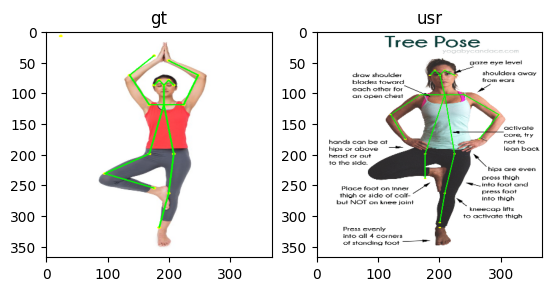

In [ ]:


if __name__ == "__main__":

    BODY_PARTS_COCO = {0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
                   5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "RHip", 9: "RKnee",
                   10: "RAnkle", 11: "LHip", 12: "LKnee", 13: "LAnkle", 14: "REye",
                   15: "LEye", 16: "REar", 17: "LEar", 18: "Background"}

    POSE_PAIRS_COCO = [[0, 1], [0, 14], [0, 15], [1, 2], [1, 5], [1, 8], [1, 11], [2, 3], [3, 4],
                    [5, 6], [6, 7], [8, 9], [9, 10], [12, 13], [11, 12], [14, 16], [15, 17]]

    protoFile = "model/pose_deploy_linevec.prototxt"
    weightsFile = "model/pose_iter_440000.caffemodel"
    gt_img_path = "/content/DATASET/TEST/tree/00000010.jpg"
    usr_img_path = "/content/DATASET/TEST/tree/00000002.jpg"
    gt_img, gt_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=gt_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    usr_img, usr_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=usr_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    gt_vectors, usr_vectors = get_valid_vectors(gt_kp, usr_kp)
    resized_gt_kp = resize_keypoints(gt_img_path, gt_kp)
    resized_usr_kp = resize_keypoints(usr_img_path, usr_kp)
    resized_gt_img=cv2.resize(gt_img, (368,368))
    resized_usr_img=cv2.resize(usr_img, (368,368))
    print("Valid Ground Truth Vectors:", gt_vectors)
    print("Valid User Vectors:", usr_vectors)

    for idx, gt_vector in gt_vectors.items():
        if idx in usr_vectors:
            usr_vector = usr_vectors[idx]
            angle, direction = calculate_angle_shift(gt_vector, usr_vector)
            print(f"Index: {idx}, Angle: {angle:.2f} degrees, Direction: {direction}")


    # 첫 번째 이미지 플로팅
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(resized_gt_img, cv2.COLOR_BGR2RGB))
    plt.title("gt")

    # 두 번째 이미지 플로팅
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(resized_usr_img, cv2.COLOR_BGR2RGB))
    plt.title("usr")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    ## oks 계산에 필요한 area 계산 ##
    gt = cv2.imread(gt_img_path)
    gray = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)

    KPTS_OKS_SIGMAS_COCO = torch.tensor([.26, .79, .72, .62, .79, .72, .62, 1.07, .87, .89, 1.07, .87, .89, .25, .25, 35, .35])/10.0
    tree_comment(resized_gt_kp, resized_usr_kp, gt_vectors, usr_vectors)


[pointed] Nose (0) => prob: 0.86507 / x: 323 / y: 222
[pointed] Neck (1) => prob: 0.89129 / x: 323 / y: 303
[pointed] RShoulder (2) => prob: 0.77945 / x: 283 / y: 303
[pointed] RElbow (3) => prob: 0.72202 / x: 229 / y: 181
[pointed] RWrist (4) => prob: 0.59190 / x: 296 / y: 101
[pointed] LShoulder (5) => prob: 0.72823 / x: 377 / y: 303
[pointed] LElbow (6) => prob: 0.84751 / x: 417 / y: 181
[pointed] LWrist (7) => prob: 0.58524 / x: 336 / y: 121
[pointed] RHip (8) => prob: 0.67098 / x: 283 / y: 505
[pointed] RKnee (9) => prob: 0.70900 / x: 161 / y: 586
[pointed] RAnkle (10) => prob: 0.65936 / x: 296 / y: 646
[pointed] LHip (11) => prob: 0.56463 / x: 350 / y: 505
[pointed] LKnee (12) => prob: 0.55806 / x: 336 / y: 667
[pointed] LAnkle (13) => prob: 0.61092 / x: 310 / y: 808
[pointed] REye (14) => prob: 0.79338 / x: 310 / y: 202
[pointed] LEye (15) => prob: 0.76083 / x: 336 / y: 202
[pointed] REar (16) => prob: 0.77753 / x: 296 / y: 222
[pointed] LEar (17) => prob: 0.87396 / x: 350 / y: 

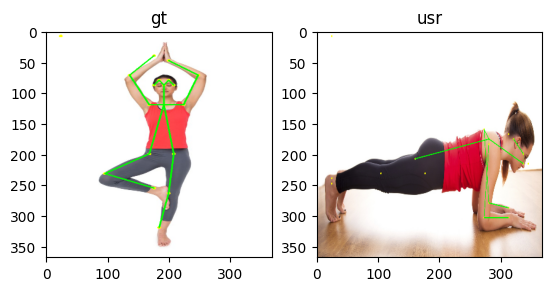

In [ ]:


if __name__ == "__main__":

    BODY_PARTS_COCO = {0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
                   5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "RHip", 9: "RKnee",
                   10: "RAnkle", 11: "LHip", 12: "LKnee", 13: "LAnkle", 14: "REye",
                   15: "LEye", 16: "REar", 17: "LEar", 18: "Background"}

    POSE_PAIRS_COCO = [[0, 1], [0, 14], [0, 15], [1, 2], [1, 5], [1, 8], [1, 11], [2, 3], [3, 4],
                    [5, 6], [6, 7], [8, 9], [9, 10], [12, 13], [11, 12], [14, 16], [15, 17]]

    protoFile = "model/pose_deploy_linevec.prototxt"
    weightsFile = "model/pose_iter_440000.caffemodel"
    gt_img_path = "/content/DATASET/TEST/tree/00000010.jpg"
    usr_img_path = "/content/DATASET/TEST/plank/00000002.jpg"
    gt_img, gt_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=gt_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    usr_img, usr_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=usr_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    gt_vectors, usr_vectors = get_valid_vectors(gt_kp, usr_kp)
    resized_gt_kp = resize_keypoints(gt_img_path, gt_kp)
    resized_usr_kp = resize_keypoints(usr_img_path, usr_kp)
    resized_gt_img=cv2.resize(gt_img, (368,368))
    resized_usr_img=cv2.resize(usr_img, (368,368))
    print("Valid Ground Truth Vectors:", gt_vectors)
    print("Valid User Vectors:", usr_vectors)

    for idx, gt_vector in gt_vectors.items():
        if idx in usr_vectors:
            usr_vector = usr_vectors[idx]
            angle, direction = calculate_angle_shift(gt_vector, usr_vector)
            print(f"Index: {idx}, Angle: {angle:.2f} degrees, Direction: {direction}")


    # 첫 번째 이미지 플로팅
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(resized_gt_img, cv2.COLOR_BGR2RGB))
    plt.title("gt")

    # 두 번째 이미지 플로팅
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(resized_usr_img, cv2.COLOR_BGR2RGB))
    plt.title("usr")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    ## oks 계산에 필요한 area 계산 ##
    gt = cv2.imread(gt_img_path)
    gray = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)

    KPTS_OKS_SIGMAS_COCO = torch.tensor([.26, .79, .72, .62, .79, .72, .62, 1.07, .87, .89, 1.07, .87, .89, .25, .25, 35, .35])/10.0
    tree_comment(resized_gt_kp, resized_usr_kp, gt_vectors, usr_vectors)


[pointed] Nose (0) => prob: 0.86507 / x: 323 / y: 222
[pointed] Neck (1) => prob: 0.89129 / x: 323 / y: 303
[pointed] RShoulder (2) => prob: 0.77945 / x: 283 / y: 303
[pointed] RElbow (3) => prob: 0.72202 / x: 229 / y: 181
[pointed] RWrist (4) => prob: 0.59190 / x: 296 / y: 101
[pointed] LShoulder (5) => prob: 0.72823 / x: 377 / y: 303
[pointed] LElbow (6) => prob: 0.84751 / x: 417 / y: 181
[pointed] LWrist (7) => prob: 0.58524 / x: 336 / y: 121
[pointed] RHip (8) => prob: 0.67098 / x: 283 / y: 505
[pointed] RKnee (9) => prob: 0.70900 / x: 161 / y: 586
[pointed] RAnkle (10) => prob: 0.65936 / x: 296 / y: 646
[pointed] LHip (11) => prob: 0.56463 / x: 350 / y: 505
[pointed] LKnee (12) => prob: 0.55806 / x: 336 / y: 667
[pointed] LAnkle (13) => prob: 0.61092 / x: 310 / y: 808
[pointed] REye (14) => prob: 0.79338 / x: 310 / y: 202
[pointed] LEye (15) => prob: 0.76083 / x: 336 / y: 202
[pointed] REar (16) => prob: 0.77753 / x: 296 / y: 222
[pointed] LEar (17) => prob: 0.87396 / x: 350 / y: 

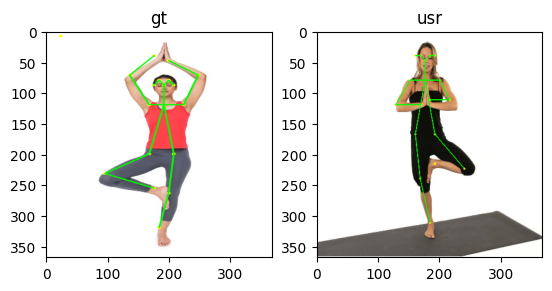

In [ ]:


if __name__ == "__main__":

    BODY_PARTS_COCO = {0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
                   5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "RHip", 9: "RKnee",
                   10: "RAnkle", 11: "LHip", 12: "LKnee", 13: "LAnkle", 14: "REye",
                   15: "LEye", 16: "REar", 17: "LEar", 18: "Background"}

    POSE_PAIRS_COCO = [[0, 1], [0, 14], [0, 15], [1, 2], [1, 5], [1, 8], [1, 11], [2, 3], [3, 4],
                    [5, 6], [6, 7], [8, 9], [9, 10], [12, 13], [11, 12], [14, 16], [15, 17]]

    protoFile = "model/pose_deploy_linevec.prototxt"
    weightsFile = "model/pose_iter_440000.caffemodel"
    gt_img_path = "/content/DATASET/TEST/tree/00000010.jpg"
    usr_img_path = "/content/DATASET/TEST/tree/00000008.jpg"
    gt_img, gt_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=gt_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    usr_img, usr_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=usr_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    gt_vectors, usr_vectors = get_valid_vectors(gt_kp, usr_kp)
    resized_gt_kp = resize_keypoints(gt_img_path, gt_kp)
    resized_usr_kp = resize_keypoints(usr_img_path, usr_kp)
    resized_gt_img=cv2.resize(gt_img, (368,368))
    resized_usr_img=cv2.resize(usr_img, (368,368))
    print("Valid Ground Truth Vectors:", gt_vectors)
    print("Valid User Vectors:", usr_vectors)

    for idx, gt_vector in gt_vectors.items():
        if idx in usr_vectors:
            usr_vector = usr_vectors[idx]
            angle, direction = calculate_angle_shift(gt_vector, usr_vector)
            print(f"Index: {idx}, Angle: {angle:.2f} degrees, Direction: {direction}")


    # 첫 번째 이미지 플로팅
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(resized_gt_img, cv2.COLOR_BGR2RGB))
    plt.title("gt")

    # 두 번째 이미지 플로팅
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(resized_usr_img, cv2.COLOR_BGR2RGB))
    plt.title("usr")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    ## oks 계산에 필요한 area 계산 ##
    gt = cv2.imread(gt_img_path)
    gray = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)

    KPTS_OKS_SIGMAS_COCO = torch.tensor([.26, .79, .72, .62, .79, .72, .62, 1.07, .87, .89, 1.07, .87, .89, .25, .25, 35, .35])/10.0
    tree_comment(resized_gt_kp, resized_usr_kp, gt_vectors, usr_vectors)


[pointed] Nose (0) => prob: 0.86507 / x: 323 / y: 222
[pointed] Neck (1) => prob: 0.89129 / x: 323 / y: 303
[pointed] RShoulder (2) => prob: 0.77945 / x: 283 / y: 303
[pointed] RElbow (3) => prob: 0.72202 / x: 229 / y: 181
[pointed] RWrist (4) => prob: 0.59190 / x: 296 / y: 101
[pointed] LShoulder (5) => prob: 0.72823 / x: 377 / y: 303
[pointed] LElbow (6) => prob: 0.84751 / x: 417 / y: 181
[pointed] LWrist (7) => prob: 0.58524 / x: 336 / y: 121
[pointed] RHip (8) => prob: 0.67098 / x: 283 / y: 505
[pointed] RKnee (9) => prob: 0.70900 / x: 161 / y: 586
[pointed] RAnkle (10) => prob: 0.65936 / x: 296 / y: 646
[pointed] LHip (11) => prob: 0.56463 / x: 350 / y: 505
[pointed] LKnee (12) => prob: 0.55806 / x: 336 / y: 667
[pointed] LAnkle (13) => prob: 0.61092 / x: 310 / y: 808
[pointed] REye (14) => prob: 0.79338 / x: 310 / y: 202
[pointed] LEye (15) => prob: 0.76083 / x: 336 / y: 202
[pointed] REar (16) => prob: 0.77753 / x: 296 / y: 222
[pointed] LEar (17) => prob: 0.87396 / x: 350 / y: 

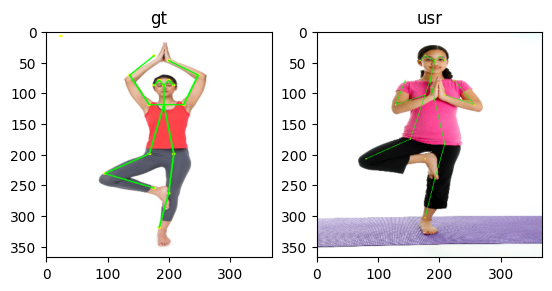

In [ ]:


if __name__ == "__main__":

    BODY_PARTS_COCO = {0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
                   5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "RHip", 9: "RKnee",
                   10: "RAnkle", 11: "LHip", 12: "LKnee", 13: "LAnkle", 14: "REye",
                   15: "LEye", 16: "REar", 17: "LEar", 18: "Background"}

    POSE_PAIRS_COCO = [[0, 1], [0, 14], [0, 15], [1, 2], [1, 5], [1, 8], [1, 11], [2, 3], [3, 4],
                    [5, 6], [6, 7], [8, 9], [9, 10], [12, 13], [11, 12], [14, 16], [15, 17]]

    protoFile = "model/pose_deploy_linevec.prototxt"
    weightsFile = "model/pose_iter_440000.caffemodel"
    gt_img_path = "/content/DATASET/TEST/tree/00000010.jpg"
    usr_img_path = "/content/DATASET/TEST/tree/00000005.jpg"
    gt_img, gt_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=gt_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    usr_img, usr_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=usr_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    gt_vectors, usr_vectors = get_valid_vectors(gt_kp, usr_kp)
    resized_gt_kp = resize_keypoints(gt_img_path, gt_kp)
    resized_usr_kp = resize_keypoints(usr_img_path, usr_kp)
    resized_gt_img=cv2.resize(gt_img, (368,368))
    resized_usr_img=cv2.resize(usr_img, (368,368))
    print("Valid Ground Truth Vectors:", gt_vectors)
    print("Valid User Vectors:", usr_vectors)

    for idx, gt_vector in gt_vectors.items():
        if idx in usr_vectors:
            usr_vector = usr_vectors[idx]
            angle, direction = calculate_angle_shift(gt_vector, usr_vector)
            print(f"Index: {idx}, Angle: {angle:.2f} degrees, Direction: {direction}")


    # 첫 번째 이미지 플로팅
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(resized_gt_img, cv2.COLOR_BGR2RGB))
    plt.title("gt")

    # 두 번째 이미지 플로팅
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(resized_usr_img, cv2.COLOR_BGR2RGB))
    plt.title("usr")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    ## oks 계산에 필요한 area 계산 ##
    gt = cv2.imread(gt_img_path)
    gray = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)

    KPTS_OKS_SIGMAS_COCO = torch.tensor([.26, .79, .72, .62, .79, .72, .62, 1.07, .87, .89, 1.07, .87, .89, .25, .25, 35, .35])/10.0
    tree_comment(resized_gt_kp, resized_usr_kp, gt_vectors, usr_vectors)


[pointed] Nose (0) => prob: 0.86507 / x: 323 / y: 222
[pointed] Neck (1) => prob: 0.89129 / x: 323 / y: 303
[pointed] RShoulder (2) => prob: 0.77945 / x: 283 / y: 303
[pointed] RElbow (3) => prob: 0.72202 / x: 229 / y: 181
[pointed] RWrist (4) => prob: 0.59190 / x: 296 / y: 101
[pointed] LShoulder (5) => prob: 0.72823 / x: 377 / y: 303
[pointed] LElbow (6) => prob: 0.84751 / x: 417 / y: 181
[pointed] LWrist (7) => prob: 0.58524 / x: 336 / y: 121
[pointed] RHip (8) => prob: 0.67098 / x: 283 / y: 505
[pointed] RKnee (9) => prob: 0.70900 / x: 161 / y: 586
[pointed] RAnkle (10) => prob: 0.65936 / x: 296 / y: 646
[pointed] LHip (11) => prob: 0.56463 / x: 350 / y: 505
[pointed] LKnee (12) => prob: 0.55806 / x: 336 / y: 667
[pointed] LAnkle (13) => prob: 0.61092 / x: 310 / y: 808
[pointed] REye (14) => prob: 0.79338 / x: 310 / y: 202
[pointed] LEye (15) => prob: 0.76083 / x: 336 / y: 202
[pointed] REar (16) => prob: 0.77753 / x: 296 / y: 222
[pointed] LEar (17) => prob: 0.87396 / x: 350 / y: 

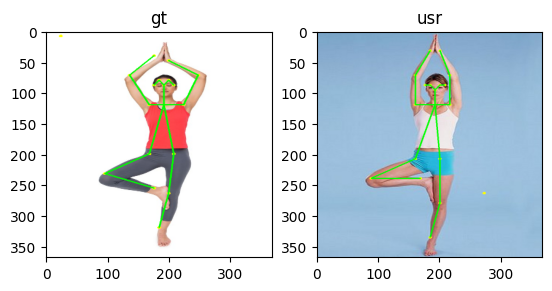

In [ ]:


if __name__ == "__main__":

    BODY_PARTS_COCO = {0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
                   5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "RHip", 9: "RKnee",
                   10: "RAnkle", 11: "LHip", 12: "LKnee", 13: "LAnkle", 14: "REye",
                   15: "LEye", 16: "REar", 17: "LEar", 18: "Background"}

    POSE_PAIRS_COCO = [[0, 1], [0, 14], [0, 15], [1, 2], [1, 5], [1, 8], [1, 11], [2, 3], [3, 4],
                    [5, 6], [6, 7], [8, 9], [9, 10], [12, 13], [11, 12], [14, 16], [15, 17]]

    protoFile = "model/pose_deploy_linevec.prototxt"
    weightsFile = "model/pose_iter_440000.caffemodel"
    gt_img_path = "/content/DATASET/TEST/tree/00000010.jpg"
    usr_img_path = "/content/DATASET/TEST/tree/00000023.jpg"
    gt_img, gt_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=gt_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    usr_img, usr_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=usr_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    gt_vectors, usr_vectors = get_valid_vectors(gt_kp, usr_kp)
    resized_gt_kp = resize_keypoints(gt_img_path, gt_kp)
    resized_usr_kp = resize_keypoints(usr_img_path, usr_kp)
    resized_gt_img=cv2.resize(gt_img, (368,368))
    resized_usr_img=cv2.resize(usr_img, (368,368))
    print("Valid Ground Truth Vectors:", gt_vectors)
    print("Valid User Vectors:", usr_vectors)

    for idx, gt_vector in gt_vectors.items():
        if idx in usr_vectors:
            usr_vector = usr_vectors[idx]
            angle, direction = calculate_angle_shift(gt_vector, usr_vector)
            print(f"Index: {idx}, Angle: {angle:.2f} degrees, Direction: {direction}")


    # 첫 번째 이미지 플로팅
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(resized_gt_img, cv2.COLOR_BGR2RGB))
    plt.title("gt")

    # 두 번째 이미지 플로팅
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(resized_usr_img, cv2.COLOR_BGR2RGB))
    plt.title("usr")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    ## oks 계산에 필요한 area 계산 ##
    gt = cv2.imread(gt_img_path)
    gray = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)

    KPTS_OKS_SIGMAS_COCO = torch.tensor([.26, .79, .72, .62, .79, .72, .62, 1.07, .87, .89, 1.07, .87, .89, .25, .25, 35, .35])/10.0
    tree_comment(resized_gt_kp, resized_usr_kp, gt_vectors, usr_vectors)


[pointed] Nose (0) => prob: 0.86507 / x: 323 / y: 222
[pointed] Neck (1) => prob: 0.89129 / x: 323 / y: 303
[pointed] RShoulder (2) => prob: 0.77945 / x: 283 / y: 303
[pointed] RElbow (3) => prob: 0.72202 / x: 229 / y: 181
[pointed] RWrist (4) => prob: 0.59190 / x: 296 / y: 101
[pointed] LShoulder (5) => prob: 0.72823 / x: 377 / y: 303
[pointed] LElbow (6) => prob: 0.84751 / x: 417 / y: 181
[pointed] LWrist (7) => prob: 0.58524 / x: 336 / y: 121
[pointed] RHip (8) => prob: 0.67098 / x: 283 / y: 505
[pointed] RKnee (9) => prob: 0.70900 / x: 161 / y: 586
[pointed] RAnkle (10) => prob: 0.65936 / x: 296 / y: 646
[pointed] LHip (11) => prob: 0.56463 / x: 350 / y: 505
[pointed] LKnee (12) => prob: 0.55806 / x: 336 / y: 667
[pointed] LAnkle (13) => prob: 0.61092 / x: 310 / y: 808
[pointed] REye (14) => prob: 0.79338 / x: 310 / y: 202
[pointed] LEye (15) => prob: 0.76083 / x: 336 / y: 202
[pointed] REar (16) => prob: 0.77753 / x: 296 / y: 222
[pointed] LEar (17) => prob: 0.87396 / x: 350 / y: 

TypeError: tree_comment() missing 2 required positional arguments: 'gt_vectors' and 'usr_vectors'

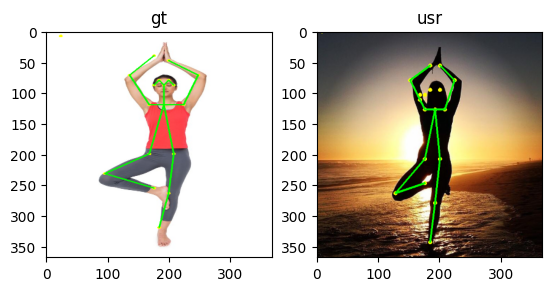

In [ ]:


if __name__ == "__main__":

    BODY_PARTS_COCO = {0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
                   5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "RHip", 9: "RKnee",
                   10: "RAnkle", 11: "LHip", 12: "LKnee", 13: "LAnkle", 14: "REye",
                   15: "LEye", 16: "REar", 17: "LEar", 18: "Background"}

    POSE_PAIRS_COCO = [[0, 1], [0, 14], [0, 15], [1, 2], [1, 5], [1, 8], [1, 11], [2, 3], [3, 4],
                    [5, 6], [6, 7], [8, 9], [9, 10], [12, 13], [11, 12], [14, 16], [15, 17]]

    protoFile = "model/pose_deploy_linevec.prototxt"
    weightsFile = "model/pose_iter_440000.caffemodel"
    gt_img_path = "/content/DATASET/TEST/tree/00000010.jpg"
    usr_img_path = "/content/DATASET/TEST/tree/00000049.jpg"
    gt_img, gt_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=gt_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    usr_img, usr_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=usr_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    gt_vectors, usr_vectors = get_valid_vectors(gt_kp, usr_kp)
    resized_gt_kp = resize_keypoints(gt_img_path, gt_kp)
    resized_usr_kp = resize_keypoints(usr_img_path, usr_kp)
    resized_gt_img=cv2.resize(gt_img, (368,368))
    resized_usr_img=cv2.resize(usr_img, (368,368))
    print("Valid Ground Truth Vectors:", gt_vectors)
    print("Valid User Vectors:", usr_vectors)

    for idx, gt_vector in gt_vectors.items():
        if idx in usr_vectors:
            usr_vector = usr_vectors[idx]
            angle, direction = calculate_angle_shift(gt_vector, usr_vector)
            print(f"Index: {idx}, Angle: {angle:.2f} degrees, Direction: {direction}")


    # 첫 번째 이미지 플로팅
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(resized_gt_img, cv2.COLOR_BGR2RGB))
    plt.title("gt")

    # 두 번째 이미지 플로팅
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(resized_usr_img, cv2.COLOR_BGR2RGB))
    plt.title("usr")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    ## oks 계산에 필요한 area 계산 ##
    gt = cv2.imread(gt_img_path)
    gray = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)

    KPTS_OKS_SIGMAS_COCO = torch.tensor([.26, .79, .72, .62, .79, .72, .62, 1.07, .87, .89, 1.07, .87, .89, .25, .25, 35, .35])/10.0
    tree_comment(resized_gt_kp, resized_usr_kp)


[pointed] Nose (0) => prob: 0.86507 / x: 323 / y: 222
[pointed] Neck (1) => prob: 0.89129 / x: 323 / y: 303
[pointed] RShoulder (2) => prob: 0.77945 / x: 283 / y: 303
[pointed] RElbow (3) => prob: 0.72202 / x: 229 / y: 181
[pointed] RWrist (4) => prob: 0.59190 / x: 296 / y: 101
[pointed] LShoulder (5) => prob: 0.72823 / x: 377 / y: 303
[pointed] LElbow (6) => prob: 0.84751 / x: 417 / y: 181
[pointed] LWrist (7) => prob: 0.58524 / x: 336 / y: 121
[pointed] RHip (8) => prob: 0.67098 / x: 283 / y: 505
[pointed] RKnee (9) => prob: 0.70900 / x: 161 / y: 586
[pointed] RAnkle (10) => prob: 0.65936 / x: 296 / y: 646
[pointed] LHip (11) => prob: 0.56463 / x: 350 / y: 505
[pointed] LKnee (12) => prob: 0.55806 / x: 336 / y: 667
[pointed] LAnkle (13) => prob: 0.61092 / x: 310 / y: 808
[pointed] REye (14) => prob: 0.79338 / x: 310 / y: 202
[pointed] LEye (15) => prob: 0.76083 / x: 336 / y: 202
[pointed] REar (16) => prob: 0.77753 / x: 296 / y: 222
[pointed] LEar (17) => prob: 0.87396 / x: 350 / y: 

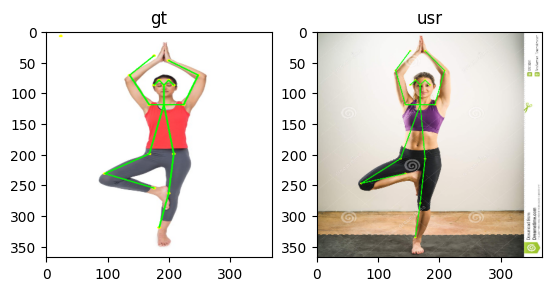

In [ ]:


if __name__ == "__main__":

    BODY_PARTS_COCO = {0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
                   5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "RHip", 9: "RKnee",
                   10: "RAnkle", 11: "LHip", 12: "LKnee", 13: "LAnkle", 14: "REye",
                   15: "LEye", 16: "REar", 17: "LEar", 18: "Background"}

    POSE_PAIRS_COCO = [[0, 1], [0, 14], [0, 15], [1, 2], [1, 5], [1, 8], [1, 11], [2, 3], [3, 4],
                    [5, 6], [6, 7], [8, 9], [9, 10], [12, 13], [11, 12], [14, 16], [15, 17]]

    protoFile = "model/pose_deploy_linevec.prototxt"
    weightsFile = "model/pose_iter_440000.caffemodel"
    gt_img_path = "/content/DATASET/TEST/tree/00000010.jpg"
    usr_img_path = "/content/DATASET/TRAIN/tree/File73.jpg"
    gt_img, gt_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=gt_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    usr_img, usr_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=usr_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    gt_vectors, usr_vectors = get_valid_vectors(gt_kp, usr_kp)
    resized_gt_kp = resize_keypoints(gt_img_path, gt_kp)
    resized_usr_kp = resize_keypoints(usr_img_path, usr_kp)
    resized_gt_img=cv2.resize(gt_img, (368,368))
    resized_usr_img=cv2.resize(usr_img, (368,368))
    print("Valid Ground Truth Vectors:", gt_vectors)
    print("Valid User Vectors:", usr_vectors)

    for idx, gt_vector in gt_vectors.items():
        if idx in usr_vectors:
            usr_vector = usr_vectors[idx]
            angle, direction = calculate_angle_shift(gt_vector, usr_vector)
            print(f"Index: {idx}, Angle: {angle:.2f} degrees, Direction: {direction}")


    # 첫 번째 이미지 플로팅
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(resized_gt_img, cv2.COLOR_BGR2RGB))
    plt.title("gt")

    # 두 번째 이미지 플로팅
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(resized_usr_img, cv2.COLOR_BGR2RGB))
    plt.title("usr")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    ## oks 계산에 필요한 area 계산 ##
    gt = cv2.imread(gt_img_path)
    gray = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)

    KPTS_OKS_SIGMAS_COCO = torch.tensor([.26, .79, .72, .62, .79, .72, .62, 1.07, .87, .89, 1.07, .87, .89, .25, .25, 35, .35])/10.0
    tree_comment(resized_gt_kp, resized_usr_kp, gt_vectors, usr_vectors)


[pointed] Nose (0) => prob: 0.86507 / x: 323 / y: 222
[pointed] Neck (1) => prob: 0.89129 / x: 323 / y: 303
[pointed] RShoulder (2) => prob: 0.77945 / x: 283 / y: 303
[pointed] RElbow (3) => prob: 0.72202 / x: 229 / y: 181
[pointed] RWrist (4) => prob: 0.59190 / x: 296 / y: 101
[pointed] LShoulder (5) => prob: 0.72823 / x: 377 / y: 303
[pointed] LElbow (6) => prob: 0.84751 / x: 417 / y: 181
[pointed] LWrist (7) => prob: 0.58524 / x: 336 / y: 121
[pointed] RHip (8) => prob: 0.67098 / x: 283 / y: 505
[pointed] RKnee (9) => prob: 0.70900 / x: 161 / y: 586
[pointed] RAnkle (10) => prob: 0.65936 / x: 296 / y: 646
[pointed] LHip (11) => prob: 0.56463 / x: 350 / y: 505
[pointed] LKnee (12) => prob: 0.55806 / x: 336 / y: 667
[pointed] LAnkle (13) => prob: 0.61092 / x: 310 / y: 808
[pointed] REye (14) => prob: 0.79338 / x: 310 / y: 202
[pointed] LEye (15) => prob: 0.76083 / x: 336 / y: 202
[pointed] REar (16) => prob: 0.77753 / x: 296 / y: 222
[pointed] LEar (17) => prob: 0.87396 / x: 350 / y: 

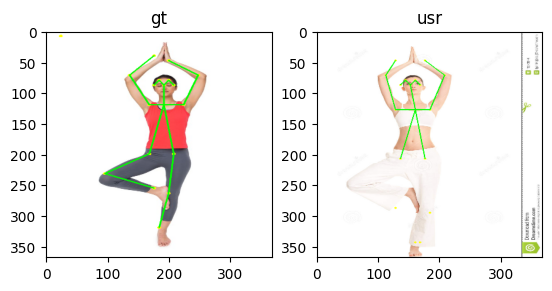

In [ ]:


if __name__ == "__main__":

    BODY_PARTS_COCO = {0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
                   5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "RHip", 9: "RKnee",
                   10: "RAnkle", 11: "LHip", 12: "LKnee", 13: "LAnkle", 14: "REye",
                   15: "LEye", 16: "REar", 17: "LEar", 18: "Background"}

    POSE_PAIRS_COCO = [[0, 1], [0, 14], [0, 15], [1, 2], [1, 5], [1, 8], [1, 11], [2, 3], [3, 4],
                    [5, 6], [6, 7], [8, 9], [9, 10], [12, 13], [11, 12], [14, 16], [15, 17]]

    protoFile = "model/pose_deploy_linevec.prototxt"
    weightsFile = "model/pose_iter_440000.caffemodel"
    gt_img_path = "/content/DATASET/TEST/tree/00000010.jpg"
    usr_img_path = "/content/DATASET/TRAIN/tree/File31.jpg"
    gt_img, gt_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=gt_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    usr_img, usr_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=usr_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    gt_vectors, usr_vectors = get_valid_vectors(gt_kp, usr_kp)
    resized_gt_kp = resize_keypoints(gt_img_path, gt_kp)
    resized_usr_kp = resize_keypoints(usr_img_path, usr_kp)
    resized_gt_img=cv2.resize(gt_img, (368,368))
    resized_usr_img=cv2.resize(usr_img, (368,368))
    print("Valid Ground Truth Vectors:", gt_vectors)
    print("Valid User Vectors:", usr_vectors)

    for idx, gt_vector in gt_vectors.items():
        if idx in usr_vectors:
            usr_vector = usr_vectors[idx]
            angle, direction = calculate_angle_shift(gt_vector, usr_vector)
            print(f"Index: {idx}, Angle: {angle:.2f} degrees, Direction: {direction}")


    # 첫 번째 이미지 플로팅
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(resized_gt_img, cv2.COLOR_BGR2RGB))
    plt.title("gt")

    # 두 번째 이미지 플로팅
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(resized_usr_img, cv2.COLOR_BGR2RGB))
    plt.title("usr")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    ## oks 계산에 필요한 area 계산 ##
    gt = cv2.imread(gt_img_path)
    gray = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)

    KPTS_OKS_SIGMAS_COCO = torch.tensor([.26, .79, .72, .62, .79, .72, .62, 1.07, .87, .89, 1.07, .87, .89, .25, .25, 35, .35])/10.0
    tree_comment(resized_gt_kp, resized_usr_kp)


[pointed] Nose (0) => prob: 0.86507 / x: 323 / y: 222
[pointed] Neck (1) => prob: 0.89129 / x: 323 / y: 303
[pointed] RShoulder (2) => prob: 0.77945 / x: 283 / y: 303
[pointed] RElbow (3) => prob: 0.72202 / x: 229 / y: 181
[pointed] RWrist (4) => prob: 0.59190 / x: 296 / y: 101
[pointed] LShoulder (5) => prob: 0.72823 / x: 377 / y: 303
[pointed] LElbow (6) => prob: 0.84751 / x: 417 / y: 181
[pointed] LWrist (7) => prob: 0.58524 / x: 336 / y: 121
[pointed] RHip (8) => prob: 0.67098 / x: 283 / y: 505
[pointed] RKnee (9) => prob: 0.70900 / x: 161 / y: 586
[pointed] RAnkle (10) => prob: 0.65936 / x: 296 / y: 646
[pointed] LHip (11) => prob: 0.56463 / x: 350 / y: 505
[pointed] LKnee (12) => prob: 0.55806 / x: 336 / y: 667
[pointed] LAnkle (13) => prob: 0.61092 / x: 310 / y: 808
[pointed] REye (14) => prob: 0.79338 / x: 310 / y: 202
[pointed] LEye (15) => prob: 0.76083 / x: 336 / y: 202
[pointed] REar (16) => prob: 0.77753 / x: 296 / y: 222
[pointed] LEar (17) => prob: 0.87396 / x: 350 / y: 

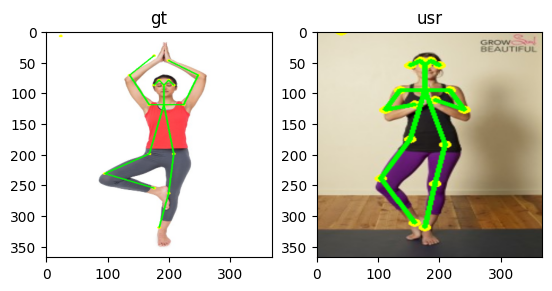

In [ ]:


if __name__ == "__main__":

    BODY_PARTS_COCO = {0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
                   5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "RHip", 9: "RKnee",
                   10: "RAnkle", 11: "LHip", 12: "LKnee", 13: "LAnkle", 14: "REye",
                   15: "LEye", 16: "REar", 17: "LEar", 18: "Background"}

    POSE_PAIRS_COCO = [[0, 1], [0, 14], [0, 15], [1, 2], [1, 5], [1, 8], [1, 11], [2, 3], [3, 4],
                    [5, 6], [6, 7], [8, 9], [9, 10], [12, 13], [11, 12], [14, 16], [15, 17]]

    protoFile = "model/pose_deploy_linevec.prototxt"
    weightsFile = "model/pose_iter_440000.caffemodel"
    gt_img_path = "/content/DATASET/TEST/tree/00000010.jpg"
    usr_img_path = "/content/IMG_3615.jpg"
    gt_img, gt_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=gt_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    usr_img, usr_kp = output_keypoints_with_lines_image(proto_file=protoFile, weights_file=weightsFile, image_path=usr_img_path,
                                    threshold=0.1, BODY_PARTS=BODY_PARTS_COCO, POSE_PAIRS=POSE_PAIRS_COCO)
    gt_vectors, usr_vectors = get_valid_vectors(gt_kp, usr_kp)
    resized_gt_kp = resize_keypoints(gt_img_path, gt_kp)
    resized_usr_kp = resize_keypoints(usr_img_path, usr_kp)
    resized_gt_img=cv2.resize(gt_img, (368,368))
    resized_usr_img=cv2.resize(usr_img, (368,368))
    print("Valid Ground Truth Vectors:", gt_vectors)
    print("Valid User Vectors:", usr_vectors)

    for idx, gt_vector in gt_vectors.items():
        if idx in usr_vectors:
            usr_vector = usr_vectors[idx]
            angle, direction = calculate_angle_shift(gt_vector, usr_vector)
            print(f"Index: {idx}, Angle: {angle:.2f} degrees, Direction: {direction}")


    # 첫 번째 이미지 플로팅
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(resized_gt_img, cv2.COLOR_BGR2RGB))
    plt.title("gt")

    # 두 번째 이미지 플로팅
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(resized_usr_img, cv2.COLOR_BGR2RGB))
    plt.title("usr")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    ## oks 계산에 필요한 area 계산 ##
    gt = cv2.imread(gt_img_path)
    gray = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)

    KPTS_OKS_SIGMAS_COCO = torch.tensor([.26, .79, .72, .62, .79, .72, .62, 1.07, .87, .89, 1.07, .87, .89, .25, .25, 35, .35])/10.0
    tree_comment(resized_gt_kp, resized_usr_kp)
